In [17]:
import numpy as np
import rpy2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import iqr
import matplotlib.pyplot as plt
from numba import jit
from itertools import product
import pandas as pd

In [18]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [19]:
# import R's "base" package
base = importr('base')
# import R's "utils" package
utils = importr('utils')
quantregForest = importr('quantregForest')

In [20]:
def tune_nodesize_quantile_forest(X, y, nodesize_grid, pred_band_method, n_simulations):
    result_mat = np.zeros((len(nodesize_grid),n_simulations))
    
    for j, node_val in enumerate(nodesize_grid):
        for i in range(n_simulations):
            X_train, X_split_again, y_train, y_split_again = train_test_split(X, y, test_size=0.4, train_size=0.6)
            X_cv, X_calibrate, y_cv, y_calibrate = train_test_split(X_split_again, y_split_again, test_size = 0.5, train_size =0.5)

            # returns array with lower- and upper prediction boundaries for each observation in y_cv
            # pred_band_y_cv = pred_band_method(x_new = X_cv, X_train = X_train, y_train=y_train, X_test=X_calibrate, y_test=y_calibrate, nodesize=node_val)
            pred_band_y_cv = pred_band_method(X_predict = X_cv, X_train = X_train, y_train=y_train, X_conf=X_calibrate, y_conf=y_calibrate, nodesize=node_val)
            
            length_intervals = pred_band_y_cv[:,1] - pred_band_y_cv[:,0]
            criterion = np.mean(length_intervals)
            result_mat[j,i] = criterion
        
    minimal_average_length_nodesize_index = np.argmin(np.mean(result_mat, axis=1))
    minimal_average_length_nodesize = nodesize_grid[minimal_average_length_nodesize_index]
    return minimal_average_length_nodesize, result_mat

def tune_mean_based_rf(X, y, min_samples_leaf_grid, pred_band_method, n_simulations):
    result_mat = np.zeros((len(min_samples_leaf_grid),n_simulations))
    
    for j, min_samples_leaf_val in enumerate(min_samples_leaf_grid):
        for i in range(n_simulations):
            X_train, X_split_again, y_train, y_split_again = train_test_split(X, y, test_size=0.4, train_size=0.6)
            X_cv, X_calibrate, y_cv, y_calibrate = train_test_split(X_split_again, y_split_again, test_size = 0.5, train_size =0.5)

            # returns array with lower- and upper prediction boundaries for each observation in y_cv
            pred_band_y_cv = pred_band_method(X_predict = X_cv, X_train = X_train, y_train=y_train, X_conf=X_calibrate, y_conf=y_calibrate, min_samples_leaf=min_samples_leaf_val)
            
            length_intervals = pred_band_y_cv[:,1] - pred_band_y_cv[:,0]
            criterion = np.mean(length_intervals)
            result_mat[j,i] = criterion
        
    minimal_average_length_nodesize_index = np.argmin(np.mean(result_mat, axis=1))
    minimal_average_length_nodesize = min_samples_leaf_grid[minimal_average_length_nodesize_index]
    return minimal_average_length_nodesize, result_mat


In [21]:
def numpy_matrix_to_r_matrix(np_mat):
    if len(np_mat.shape) == 1:
        np_mat = np.atleast_2d(np_mat).T
    nr,nc = np_mat.shape
    r_mat = robjects.r.matrix(np_mat, nrow=nr, ncol=nc)
    return r_mat

# 90% coverage, i.e. alpha = 0.1
# still used for cross validation where only predictions for one test set is needed
quantreg_forest = robjects.r('''
f_simple <- function(X_train, y_train, X_test, lower, upper, nodesize){
    if(dim(X_train)[2] >= 3){
        mtry = round(dim(X_train)[2] / 3)
    }
    else{
        mtry = 1
    }
        
    qrf <- quantregForest(x=X_train, y=y_train, nodesize=nodesize, mtry=mtry, ntree=1000)
    conditionalQuantiles  <- predict(object=qrf,  newdata=X_test, what = c(lower, upper))
    return(conditionalQuantiles)
}''')


# outdated: used for the conf. inference based on the cumulative density function
quantreg_forest_grid_old = robjects.r('''
g_old <- function(X_train, y_train, X_test, alpha_grid, nodesize){
    if(dim(X_train)[2] >= 3){
        mtry = round(dim(X_train)[2] / 3)
    }
    else{
        mtry = 1
    }
    qrf <- quantregForest(x=X_train, y=y_train, nodesize=nodesize, mtry=mtry, ntree=1000)
    conditionalQuantiles  <- predict(object=qrf,  newdata=X_test, what = alpha_grid)
    return(conditionalQuantiles)
}''')


# used for the conf. inference based on the cumulative density function
quantreg_forest_grid = robjects.r('''
g <- function(X_predict, X_train, y_train, X_conf, alpha_grid, nodesize){

    if(dim(X_train)[2] >= 3){
        mtry = round(dim(X_train)[2] / 3)
    }
    else{
        mtry = 1
    }
    
    qrf <- quantregForest(x=X_train, y=y_train, nodesize=nodesize, mtry=mtry, ntree=1000)
    
    conditionalQuantiles_conf  <- predict(object=qrf, newdata=X_conf, what = alpha_grid)
    conditionalQuantiles_predict <- predict(object=qrf, newdata=X_predict, what = alpha_grid)
    
    return(list(conditionalQuantiles_conf, conditionalQuantiles_predict))
}''')


# used for the conformal inference based on quantile regression
quantreg_forest_beta = robjects.r('''
f <- function(X_predict, X_train, y_train, X_conf, lower, upper, nodesize){
    if(dim(X_train)[2] >= 3){
        mtry = round(dim(X_train)[2] / 3)
    }
    else{
        mtry = 1
    }
        
    qrf <- quantregForest(x=X_train, y=y_train, nodesize=nodesize, mtry=mtry, ntree=1000)
    conditionalQuantiles_conf  <- predict(object=qrf, newdata=X_conf, what = c(lower, upper))
    conditionalQuantiles_predict <- predict(object=qrf, newdata=X_predict, what = c(lower, upper))
    
    return(list(conditionalQuantiles_conf, conditionalQuantiles_predict))
}''')


In [22]:
def standardize_data(data):
    scaler = StandardScaler().fit(data)
    std_data = scaler.transform(data)
    return std_data

def standardize_conformal(X_train, y_train, X_conformalize, y_conformalize, X_test, y_test):
    
    #y_merged = np.concatenate((y_train, y_conformalize, y_test)).reshape(-1, 1)
    #X_merged = np.concatenate((X_train,X_conformalize,X_test), axis= 0)
    
    X_train_scaler = StandardScaler().fit(X_train)
    #y_train_scaler = MaxAbsScaler().fit(y_train)
    
    X_train_std = X_train_scaler.transform(X_train)
    X_conformalize_std = X_train_scaler.transform(X_conformalize)
    X_test_std = X_train_scaler.transform(X_test)
    
    #y_train_std = y_train_scaler.transform(y_train)
    #y_conformalize_std = y_train_scaler.transform(y_conformalize)
    #y_test_std = y_train_scaler.transform(y_test)
    
    return X_train_std, y_train, X_conformalize_std, y_conformalize, X_test_std, y_test


def split_sample(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test



def OLS(X_predict, X_train, y_train, X_conf, intercept=True, fit_training_sample_preds=False):
    
    model = LinearRegression(fit_intercept=intercept)
    model.fit(X_train, y_train)
    
    mu_hat_x_conf = model.predict(X_conf)
    mu_hat_x_predict = model.predict(X_predict)
    mu_hat_x_train = model.predict(X_train)
    
    return mu_hat_x_predict, mu_hat_x_train, mu_hat_x_conf


def random_forest(X_predict, X_train, y_train, X_conf, n_estimators=1000, nodesize=40, max_features=None):
    
    if max_features is None:
        if X_train.shape[1] > 1:   
            max_features = round(X_train.shape[1] / 3)
        elif X_train.shape[1] == 1:
            max_features = 1
        else:
            raise ValueError('X has a dimensionality problem, missing regressors.')
    
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  min_samples_leaf=nodesize,
                                  max_features=max_features)
    
    model.fit(X_train, y_train)
    
    mu_hat_x_conf = model.predict(X_conf)
    mu_hat_x_predict = model.predict(X_predict)
    mu_hat_x_train = model.predict(X_train)
    
    return mu_hat_x_predict, mu_hat_x_train, mu_hat_x_conf
    

def absolute_dev_from_mean(y_conf, mu_hat_x_conf):
    return np.abs(y_conf-mu_hat_x_conf)

def weighted_absolute_dev_from_mean(y_conf, mu_hat_x_conf, mad_hat_x_conf):
    return np.abs(y_conf-mu_hat_x_conf) / mad_hat_x_conf

def CQR_conformity_score(lower_quant_hat, upper_quant_hat, y_conf):
    first_arg = lower_quant_hat.flatten() - y_conf.flatten()
    second_arg = y_conf.flatten() - upper_quant_hat.flatten()
    conf_args = np.column_stack((first_arg, second_arg))
    return np.max(conf_args, axis=1)


In [23]:
def pred_band_mean_based(X_predict,
                         X_train,
                         y_train,
                         X_conf,
                         y_conf,
                         algorithm=random_forest,
                         alpha=0.1,
                         **args
                         ):
    
    # algorithm used to calculated mu_hat
    mu_hat_x_predict, mu_hat_x_train, mu_hat_x_conf = algorithm(X_predict=X_predict,
                                                            X_train= X_train, 
                                                            y_train=y_train,
                                                            X_conf=X_conf,
                                                            **args)
    
    conf_scores = absolute_dev_from_mean(y_conf=y_conf.flatten(), mu_hat_x_conf=mu_hat_x_conf.flatten())
    k = (1-alpha) * (1.0/len(y_conf) + 1)
    d = np.quantile(conf_scores, k)

    pred_band_upper = mu_hat_x_predict + d
    pred_band_lower = mu_hat_x_predict - d
    
    res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)

    return res

In [24]:
def pred_band_weighted_mean_based(X_predict,
                         X_train,
                         y_train,
                         X_conf,
                         y_conf,
                         algorithm=random_forest,
                         alpha=0.1,
                         **args
                         ):
    
    # two step approach for locally weighted split-conformal approach, as described in Lei et al. (2017)
    
    # algorithm used to calculated mu_hat
    mu_hat_x_predict, mu_hat_x_train, mu_hat_x_conf = algorithm(X_predict=X_predict,
                                                            X_train= X_train, 
                                                            y_train=y_train,
                                                            X_conf=X_conf,
                                                            **args)
    
    fitted_absolute_residuals_train = np.abs(y_train.flatten() - mu_hat_x_train.flatten())
    
    # algorithm used to calculated mad_hat
    mad_hat_x_predict, mad_hat_x_train, mad_hat_x_conf = algorithm(X_predict=X_predict,
                                                                  X_train=X_train,
                                                                  y_train=fitted_absolute_residuals_train,
                                                                  X_conf=X_conf,
                                                                  **args)
    
    conf_scores = weighted_absolute_dev_from_mean(y_conf=y_conf.flatten(), mu_hat_x_conf=mu_hat_x_conf.flatten(), mad_hat_x_conf=mad_hat_x_conf.flatten())

    k = (1-alpha) * (1.0/len(y_conf) + 1)
    d = np.quantile(conf_scores, k)

    pred_band_upper = mu_hat_x_predict + mad_hat_x_predict * d
    pred_band_lower = mu_hat_x_predict - mad_hat_x_predict * d
    
    res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)

    return res

In [25]:
def pred_band_quantile_based_rf_old(x_new,
                         X_train,
                         y_train,
                         X_test,
                         y_test,
                         coverage_factor=0.9,
                         quantiles = [5, 95],
                         CV=True,
                         range_vals= 10,
                         num_vals=5,
                         test_ratio = 0.1,
                         random_state = 0,
                         nodesize=100
                         ):
    
    
    X_train_r = numpy_matrix_to_r_matrix(X_train)
    X_test_r = numpy_matrix_to_r_matrix(X_test)
    y_train_r = numpy_matrix_to_r_matrix(y_train)
    x_new_r = numpy_matrix_to_r_matrix(x_new)
    alpha = 1.0 - ((quantiles[1] - quantiles[0]) / 100)
    
    if CV:
        target_coverage = quantiles[1] - quantiles[0]
        grid_q_low = np.linspace(quantiles[0], quantiles[0]+range_vals, num_vals).reshape(-1,1)
        grid_q_high = np.linspace(quantiles[1],quantiles[1]-range_vals,num_vals).reshape(-1,1)
        grid_q = np.concatenate((grid_q_low,grid_q_high),1)

        cv_quantiles = CV_quantiles_rf(X=X_train,
                                      y=y_train,
                                      target_coverage=target_coverage,
                                      grid_q=grid_q,
                                      test_ratio=test_ratio,
                                      random_state = random_state,
                                      coverage_factor=coverage_factor,
                                      nodesize=nodesize)

        test_set_quantile_predictions = np.array(quantreg_forest(X_train_r, y_train_r, X_test_r, cv_quantiles[0]/100.0, cv_quantiles[1]/100.0, nodesize=nodesize))
    
    else:
        test_set_quantile_predictions = np.array(quantreg_forest(X_train_r, y_train_r, X_test_r, 0.05, 0.95, nodesize=nodesize))
        
    conf_scores = CQR_conformity_score(lower_quant_hat=test_set_quantile_predictions[:,0], upper_quant_hat=test_set_quantile_predictions[:,1], y_test=y_test)
    k = (1-alpha) * (1.0/len(y_test) + 1)
    d = np.quantile(conf_scores, k)

    
    if CV:
        x_new_quantile_pred = np.array(quantreg_forest(X_train_r, y_train_r, x_new_r, cv_quantiles[0]/100, cv_quantiles[1]/100, nodesize=nodesize))
    else:
        x_new_quantile_pred = np.array(quantreg_forest(X_train_r, y_train_r, x_new_r, 0.05, 0.95))

    pred_band_upper = x_new_quantile_pred[:,1] + d
    pred_band_lower = x_new_quantile_pred[:,0] - d
    
    res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)

    return res

In [26]:
def CV_quantiles_rf(X,
               y,
               target_coverage,
               grid_q,
               test_ratio,
               random_state,
               nodesize,
               coverage_factor=0.9):

    target_coverage = coverage_factor*target_coverage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio,random_state=random_state)
    best_avg_length = 1e10
    best_q = grid_q[0]
    
    X_train_r = numpy_matrix_to_r_matrix(X_train)
    X_test_r = numpy_matrix_to_r_matrix(X_test)
    y_train_r = numpy_matrix_to_r_matrix(y_train)
    
    for q in grid_q:
        preds = np.array(quantreg_forest(X_train_r, y_train_r, X_test_r, q[0]/100, q[1]/100, nodesize=nodesize))
        coverage, avg_length = compute_coverage_len(y_test, preds[:,0], preds[:,1])
        if (coverage >= target_coverage) and (avg_length < best_avg_length):
            best_avg_length = avg_length
            best_q = q
        else:
            break
    return best_q


def compute_coverage_len(y_test, y_lower, y_upper):
    """ Compute average coverage and length of prediction intervals
    Parameters
    ----------
    y_test : numpy array, true labels (n)
    y_lower : numpy array, estimated lower bound for the labels (n)
    y_upper : numpy array, estimated upper bound for the labels (n)
    Returns
    -------
    coverage : float, average coverage
    avg_length : float, average length
    """
    
    in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
    coverage = in_the_range / len(y_test) * 100
    avg_length = np.mean(abs(y_upper - y_lower))
    return coverage, avg_length

In [27]:
def pred_band_quantile_based_rf(X_predict,
                         X_train,
                         y_train,
                         X_conf,
                         y_conf,
                         coverage_factor=0.9,
                         quantiles = [5, 95],
                         CV=True,
                         range_vals= 10,
                         num_vals=5,
                         test_ratio = 0.1,
                         random_state = 0,
                         nodesize=100
                         ):       
    
    X_train_r = numpy_matrix_to_r_matrix(X_train)
    X_conf_r = numpy_matrix_to_r_matrix(X_conf)
    y_train_r = numpy_matrix_to_r_matrix(y_train)
    X_predict_r = numpy_matrix_to_r_matrix(X_predict)
    alpha = 1.0 - ((quantiles[1] - quantiles[0]) / 100)
    
    if CV:
        target_coverage = quantiles[1] - quantiles[0]
        grid_q_low = np.linspace(quantiles[0], quantiles[0]+range_vals, num_vals).reshape(-1,1)
        grid_q_high = np.linspace(quantiles[1],quantiles[1]-range_vals,num_vals).reshape(-1,1)
        grid_q = np.concatenate((grid_q_low,grid_q_high),1)

        cv_quantiles = CV_quantiles_rf(X=X_train,
                                      y=y_train,
                                      target_coverage=target_coverage,
                                      grid_q=grid_q,
                                      test_ratio=test_ratio,
                                      random_state = random_state,
                                      coverage_factor=coverage_factor,
                                      nodesize=nodesize)
        
        # returns predictions for X_conf and X_predict
        res = np.array(quantreg_forest_beta(X_predict=X_predict_r, 
                                            X_train=X_train_r, 
                                            y_train=y_train_r, 
                                            X_conf=X_conf_r, 
                                            lower=cv_quantiles[0]/100.0, 
                                            upper=cv_quantiles[1]/100.0, 
                                            nodesize=nodesize))
        
        #res = np.array(quantreg_forest_beta(X_train_r, y_train_r, X_test_r, x_new_r, cv_quantiles[0]/100.0, cv_quantiles[1]/100.0, nodesize=nodesize))
    
    else:
        res = np.array(quantreg_forest_beta(X_predict=X_predict_r, 
                                            X_train=X_train_r, 
                                            y_train=y_train_r, 
                                            X_conf=X_conf_r, 
                                            lower=0.05, 
                                            upper=0.95, 
                                            nodesize=nodesize))
        
        
    conf_scores = CQR_conformity_score(lower_quant_hat=res[0][:,0], upper_quant_hat=res[0][:,1], y_conf=y_conf)
    k = (1-alpha) * (1.0/len(y_conf) + 1)
    d = np.quantile(conf_scores, k)

    pred_band_upper = res[1][:,1] + d
    pred_band_lower = res[1][:,0] - d
    
    result = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
    
    return result

In [28]:
@jit(nopython=True)
def conditional_cdf_hat(y_grid, y_vec, q_hat_conf_mat, q_hat_pred_mat):
    # preallocate matrix for the predicted cdf values
    f_hat_y_mat = np.zeros((q_hat_pred_mat.shape[0], len(y_grid.flatten())))
    
    ###
    
    q_hat_conf_less_y_mat = (q_hat_conf_mat <= y_vec.reshape(-1, 1))
    f_hat_conf = (1.0 / q_hat_conf_less_y_mat.shape[1]) * np.sum(q_hat_conf_less_y_mat, axis=1)
    
    ###
    
    for i, y in enumerate(y_grid):
        q_hat_pred_less_y = (q_hat_pred_mat <= y)
        f_hat_y = (1.0 / q_hat_pred_less_y.shape[1]) * np.sum(q_hat_pred_less_y, axis=1)
    
        f_hat_y_mat[:,i] = f_hat_y
    
    return f_hat_conf, f_hat_y_mat

@jit(nopython=True)
def p_y_func(alpha, y_grid, f_hat_conf, f_hat_y_mat):
    
    f_hat_conf_abs_dev = np.abs(f_hat_conf.flatten() - 0.5)
    f_hat_y_mat_abs_dev = np.abs(f_hat_y_mat - 0.5)
    
    conf_set_list = []
    
    # fix the X_n+1 prediction point:
    for i in range(f_hat_y_mat.shape[0]):
        conf_set = []
        # fix the y grid value:
        for j, y in enumerate(y_grid):
            val = 1 / (len(f_hat_conf_abs_dev)+1) * np.sum( f_hat_y_mat_abs_dev[i,j] <= f_hat_conf_abs_dev)
            if val > alpha:
                conf_set.append(y)
    
        conf_set_list.append(conf_set)
        
    return conf_set_list


def extract_intervals(conf_set_list):
    # preallocate interval boundary matrix
    intervals = np.zeros((len(conf_set_list), 2))
    
    for i in range(len(conf_set_list)):
        intervals[i,0] = np.min(conf_set_list[i])
        intervals[i,1] = np.max(conf_set_list[i])
    
    return intervals

In [29]:
def pred_band_cdf_based_old(x_new, X_train, y_train, X_test, y_test, alpha=0.1, y_grid=None, quantile_grid=None, nodesize=40):
    
    if quantile_grid is None:
        quantile_grid = np.linspace(0.001, 0.999, 100)
        
    if y_grid is None:
        y_vals_merged = np.concatenate((y_train.flatten(), y_test.flatten()))
        y_grid_upper = np.max(y_vals_merged) + iqr(y_vals_merged)
        y_grid_lower = np.min(y_vals_merged) - iqr(y_vals_merged)
        y_grid = np.linspace(y_grid_lower, y_grid_upper, 15000)
        
    
    X_train_r = numpy_matrix_to_r_matrix(X_train)
    X_test_r = numpy_matrix_to_r_matrix(X_test)
    y_train_r = numpy_matrix_to_r_matrix(y_train)
    x_new_r = numpy_matrix_to_r_matrix(x_new)
    
    
    q_hat_train_mat = np.array(quantreg_forest_grid_old(X_train=X_train_r, y_train=y_train_r, X_test=X_test_r, alpha_grid=quantile_grid, nodesize=nodesize))
    q_hat_pred_mat = np.array(quantreg_forest_grid_old(X_train=X_train_r, y_train=y_train_r, X_test=x_new_r, alpha_grid=quantile_grid, nodesize=nodesize))

    f_hat_train, f_hat_y_mat = conditional_cdf_hat(y_grid=y_grid, y_vec=y_test, q_hat_conf_mat=q_hat_train_mat , q_hat_pred_mat=q_hat_pred_mat)
    
    conf_set_list = p_y_func(alpha=alpha, y_grid=y_grid, f_hat_conf=f_hat_train, f_hat_y_mat=f_hat_y_mat)
    
    res = extract_intervals(conf_set_list)
    
    return res

In [30]:
def pred_band_cdf_based(X_predict, X_train, y_train, X_conf, y_conf, alpha=0.1, y_grid=None, quantile_grid=None, nodesize=40):
    
    if quantile_grid is None:
        quantile_grid = np.linspace(0.001, 0.999, 100)
        
    if y_grid is None:
        y_vals_merged = np.concatenate((y_train.flatten(), y_conf.flatten()))
        y_grid_upper = np.max(y_vals_merged) + iqr(y_vals_merged)
        y_grid_lower = np.min(y_vals_merged) - iqr(y_vals_merged)
        y_grid = np.linspace(y_grid_lower, y_grid_upper, 15000)
        
    
    X_train_r = numpy_matrix_to_r_matrix(X_train)
    X_conf_r = numpy_matrix_to_r_matrix(X_conf)
    y_train_r = numpy_matrix_to_r_matrix(y_train)
    X_predict_r = numpy_matrix_to_r_matrix(X_predict)
    
    q_hat = np.array(quantreg_forest_grid(X_predict=X_predict_r, X_train=X_train_r, y_train=y_train_r, X_conf=X_conf_r, alpha_grid=quantile_grid, nodesize=nodesize))
    
    f_hat_conf, f_hat_y_mat = conditional_cdf_hat(y_grid=y_grid, y_vec=y_conf, q_hat_conf_mat=q_hat[0] , q_hat_pred_mat=q_hat[1])
    
    conf_set_list = p_y_func(alpha=alpha, y_grid=y_grid, f_hat_conf=f_hat_conf, f_hat_y_mat=f_hat_y_mat)
    
    res = extract_intervals(conf_set_list)
    
    return res

In [461]:
x, y = test_dgp(50)
x_test, y_test = test_dgp(1)

X_train, X_calib, y_train, y_calib = split_sample(X=x, y=y.reshape(-1,1), test_size=0.5)

x_new, conf_set_list, a, b =  pred_band_cdf_based(x_new=x_test, X_train=X_train, y_train=y_train, X_test=X_calib, y_test=y_calib, alpha=0.1, y_grid=None, quantile_grid=None)


In [462]:
extract_intervals(conf_set_list)

array([[-0.0254649 ,  1.54401648]])

In [ ]:
a = vector for training set pred
b = matrix for y grid pred

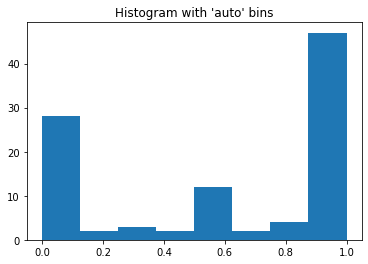

In [463]:
%matplotlib inline
_ = plt.hist(b.flatten(), bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

plt.show()

In [44]:
# (n, p, X_dist, X_correlation, eps_dist, error_type, functional_form, non_zero_beta_count, uniform_upper, method) 
index_prep = [   
    # third moment error term:
    (1000, 50, "mixture", "auto", "t", "varying_third_moment_mu", "linear", 10, 1),
    (1000, 450, "mixture", "auto", "t", "varying_third_moment_mu", "linear", 50, 1),
    # varying_squared_linear_part error term:
    (1000, 50, "uniform", "none", "normal", "varying_squared_linear_part", "sine", 10, 1),
    (1000, 450, "uniform", "none", "normal", "varying_squared_linear_part", "sine", 50, 1),
    # chernozhukov example distributional conformal prediction (2021)
    (1000, 1, "uniform", "none", "normal", "simple_linear", "linear", 1 , 1),
    # Conformalized Quantile Regression(2019), eq. 18
    (2000, 1, "uniform", "none", "normal", "simple_linear", "stochastic_poisson", 1, 5)
]

methods = {
        "pred_band_mean_based": pred_band_mean_based,
        "pred_band_weighted_mean_based": pred_band_weighted_mean_based,
        "pred_band_quantile_based_rf": pred_band_quantile_based_rf,
        "pred_band_cdf_based": pred_band_cdf_based
        }

methods_keys = list(methods.keys())


simulation_ids = np.arange(2)

index = product(index_prep, methods_keys, simulation_ids)

In [45]:
def flatten(l):
    new_l = []
    for tup in l:
        sublist = []
        for i, subelement in enumerate(tup):
            if isinstance(subelement,tuple):
                for j in subelement:
                    sublist.append(j)
            else:
                sublist.append(subelement)
        new_l.append(tuple(sublist))
    return new_l

In [46]:
index = flatten(l=list(index))

In [47]:
index = pd.MultiIndex.from_tuples(
        index,
        names=(
            "n",
            "p",
            "X_dist",
            "X_correlation",
            "eps_dist",
            "error_type",
            "functional_form",
            "non_zero_beta_count",
            "uniform_upper",
            "method",
            "simulation_id"
        ),
    )


In [48]:
df = pd.DataFrame(
    columns=[
        "mean_interval_length",
        "mean_coverage",
        "conditional_metrics_df"
    ],
    index=index,
)

In [71]:
df.head()

share_of_truth_uncovered  \
n    p  X_dist  X_correlation eps_dist error_type              functional_form non_zero_beta_count uniform_upper method                        simulation_id                            
1000 50 mixture auto          t        varying_third_moment_mu linear          10                  1             pred_band_mean_based          0                                  NaN   
                                                                                                                                               1                                  NaN   
                                                                                                                 pred_band_weighted_mean_based 0                                  NaN   
                                                                                                                                               1                                  NaN   
                                                                                                                 pred_band_quantile_based_rf   0                                  NaN   

                                                                                                                                                             ratio_total_select_coeffs_true_coeffs  
n    p  X_dist  X_correlation eps_dist error_type              functional_form non_zero_beta_count uniform_upper method                        simulation_id                                        
1000 50 mixture auto          t        varying_third_moment_mu linear          10                  1             pred_band_mean_based          0                                               NaN  
                                                                                                                                               1                                               NaN  
                                                                                                                 pred_band_weighted_mean_based 0                                               NaN  
                                                                                                                                               1                                               NaN  
                                                                                                                 pred_band_quantile_based_rf   0                                               NaN

In [57]:
for index in df.index:
    
    X = generate_X(n=index[0], p=index[1], X_dist=index[2], cor=index[3], standardize=False, uniform_upper=index[8])
    X_predict = generate_X(n=2000, p=index[1], X_dist=index[2], cor=index[3], standardize=False, uniform_upper=index[8])
    
    if index[6] == "stochastic_poisson":
        y = generate_y(X_mat=X, eps_dist=index[4], error_type=index[5], functional_form=index[6], non_zero_beta_count=index[7])
        y_predict = generate_y(X_mat=X_predict, eps_dist=index[4], error_type=index[5], functional_form=index[6], non_zero_beta_count=index[7])
    else:
        y, eps, sigma_vec, mu, beta = generate_y(X_mat=X, eps_dist=index[4], error_type=index[5], functional_form=index[6], non_zero_beta_count=index[7])
        y_predict, eps_pred, sigma_vec_pred, mu_pred, beta_pred = generate_y(X_mat=X_predict, eps_dist=index[4], error_type=index[5], functional_form=index[6], non_zero_beta_count=index[7])
    
    if (index[9] == "pred_band_quantile_based_rf") or (index[9] == "pred_band_cdf_based"):
        nodesize_opt = tune_nodesize_quantile_forest(X=X, y=y, 
                                                     nodesize_grid=[10, 25, 50, 75, 100, 125, 150, 200, 300],
                                                     pred_band_method=index[9], n_simulations=10)
        
    elif (index[9] == "pred_band_mean_based") or (index[9] == "pred_band_weighted_mean_based"):
        nodesize_opt = tune_mean_based_rf(X=X, y=y, min_samples_leaf_grid=[10, 25, 50, 75, 100, 125, 150, 200, 300], 
                                          pred_band_method=index[9], n_simulations=10)
        
    else:
        raise ValueError('A problem with the prediction band method occured.')
        

    X_train, X_conf, y_train, y_conf = split_sample(X=X, y=y.reshape(-1,1), test_size=0.5)
    
    res = methods[index[9]](X_predict=X_predict, X_train=X_train, y_train=y_train, X_conf=X_conf, y_conf=y_conf,nodesize=int(nodesize_opt))
    
    length_bands = res[:,1] - res[:,0]
    mean_interval_length = np.mean(length_bands)
    
    in_the_range = np.sum((y_predict.flatten() >= res[:,0]) & (y_predict.flatten() <= res[:,1]))
    mean_coverage = in_the_range / len(y_predict)
    
    if index[5] == "simple_linear":
        cond_var = cond_variance(X_mat=X_predict, error_type=index[5])
    else:
        linear_part = X_predict @ beta_pred
        cond_var = cond_variance(X_mat=X_predict, error_type=index[5], linear_part=linear_part)
        
    cond_metrics_df = construc_cond_metric_df(cond_variance=cond_var, result_pred_bands=res, y_predict=y_predict)
    
    
    df.at[index, "mean_interval_length"] = mean_interval_length
    df.at[index, "mean_coverage"] = mean_coverage
    df.at[index, "conditional_metrics_df"] = cond_metrics_df
    
    print(index[10])          

50
50
50
50
50
50
50
50
450
450
450
450
450
450
450
450
50
50
50
50
50
50
50
50
450
450
450
450
450
450
450
450
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [31]:
def test_dgp(nsamples):
    X = np.random.uniform(0,1,nsamples).reshape((nsamples,1))
    mu, sigma = 0, 1 # mean and standard deviation
    eps = np.random.normal(mu, sigma, nsamples)
    y = X.flatten() + X.flatten() * eps.flatten()
    y = y.reshape(-1,1)
    return X, y

In [19]:
def test_dgp_2(nsamples):
    X = np.random.uniform(0,1,nsamples*10).reshape((nsamples,10))
    mu, sigma = 0, 1 # mean and standard deviation
    eps = np.random.normal(mu, sigma, nsamples)
    y = - 1.5* X[:,0].flatten() + 2* X[:,4]**2 - 1.5* X[:,8]**2 + X[:,0].flatten() * eps.flatten()
    y = y.reshape(-1,1)
    return X, y

In [98]:
x, y = test_dgp(2000)
x_test, y_test = test_dgp(2000)

X_train, X_calib, y_train, y_calib = split_sample(X=x, y=y.reshape(-1,1), test_size=0.5)

res = pred_band_weighted_mean_based(X_predict=x_test,
                         X_train=X_train,
                         y_train=y_train,
                         X_conf=X_calib,
                         y_conf=y_calib,
                         #algorithm=random_forest,
                         alpha=0.1)


length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test.flatten() >= res[:,0]) & (y_test.flatten() <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 1.6249283956506069
CQR Random Forests: Percentage in the range (expecting 90.0%): 89.35


In [32]:
x, y = test_dgp(2000)
x_test, y_test = test_dgp(2000)

X_train, X_calib, y_train, y_calib = split_sample(X=x, y=y.reshape(-1,1), test_size=0.5)

#res = pred_band_cdf_based(x_new=x_test, X_train=X_train, y_train=y_train, X_test=X_calib, y_test=y_calib, alpha=0.1, nodesize=150)

res = pred_band_quantile_based_rf(X_predict=x_test, X_train=X_train, y_train=y_train, X_conf=X_calib, y_conf=y_calib, nodesize=50)

#res = extract_intervals(conf_set_list)

length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test.flatten() >= res[:,0]) & (y_test.flatten() <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 1.7286445420745036
CQR Random Forests: Percentage in the range (expecting 90.0%): 91.2


In [35]:
x, y = test_dgp(2000)
res, mat = tune_nodesize_quantile_forest(X=x, y=y, nodesize_grid=np.array([10,20,40,60,100,150]), pred_band_method=pred_band_quantile_based_rf, n_simulations=20)

In [27]:
x, y = test_dgp(2000)
res, mat = tune_mean_based_rf(X=x, y=y, min_samples_leaf_grid=np.array([10,20,40,60,100,150]), pred_band_method=pred_band_mean_based, n_simulations=20)

In [36]:
res

100

In [37]:
import pandas as pd

df = pd.DataFrame(mat)
df.mean(axis=1)

0    1.890472
1    1.809627
2    1.674751
3    1.671252
4    1.624533
5    1.647596
dtype: float64

In [111]:
x, y = test_dgp(2000)
x_test, y_test = test_dgp(2000)

X_train, X_calib, y_train, y_calib = split_sample(X=x, y=y.reshape(-1,1), test_size=0.5)

X_train, y_train, X_calib, y_calib, x_test, y_test  = standardize_conformal(X_train, y_train, X_calib, y_calib, x_test, y_test)

#res = np.array(pred_band_quantile_based_rf(x_new = x_test, X_train=X_train, y_train=y_train, X_test=X_calib, y_test=y_calib, CV=True, nodesize=200)).T
res = pred_band_quantile_based_rf(X_predict = x_test, X_train=X_train, y_train=y_train, X_conf=X_calib, y_conf=y_calib, CV=True, nodesize=40)

length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test.flatten() >= res[:,0]) & (y_test.flatten() <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 1.7351118363142555
CQR Random Forests: Percentage in the range (expecting 90.0%): 92.15


In [69]:
select_conditional_range = (x_test.flatten() < 0.99) & (x_test.flatten()  > 0.9)

In [70]:
in_the_cond_range = np.sum((y_test.flatten()[select_conditional_range] >= res[select_conditional_range,0]) & (y_test.flatten()[select_conditional_range] <= res[select_conditional_range,1]))

In [71]:
print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_cond_range / np.sum(select_conditional_range) * 100)

CQR Random Forests: Percentage in the range (expecting 90.0%): 89.88095238095238


In [40]:
x_test.flatten()

array([0.09674145, 0.38154993, 0.96611736, ..., 0.45365366, 0.08568194,
       0.88301005])

In [35]:
x_test.flatten() < 0.825

array([ True,  True, False, ...,  True,  True, False])

In [36]:
x_test.flatten()  > 0.775

array([False, False,  True, ..., False, False,  True])

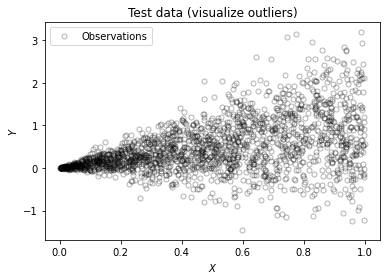

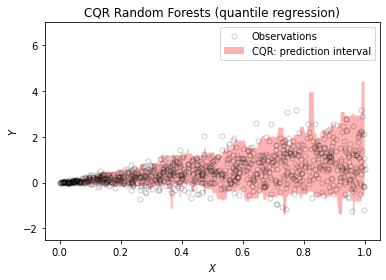

In [132]:
save_figures = False
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'red'
max_show = 1000

%matplotlib inline
# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')
if save_figures:
    plt.savefig("illustration_test_data.png",
                bbox_inches='tight', dpi=300)
plt.show()

plot_func(x=x_test,y=y_test,y_u=res[:,1],y_l=res[:,0],shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="illustration_split_qrf.png",save_figures=save_figures)

In [54]:
iterations = 1
interval_length = np.zeros(iterations)
covered = np.full((iterations,), False, dtype=bool)

X, y = test_dgp(2000)
mu, sigma = 0, 1 
X_train, X_test, y_train, y_test = split_sample(X=X, y=y, test_size=0.5, scale=True)
x_new = np.array([[0.1],[0.2]])
y_new = x_new.flatten() + x_new.flatten() * np.random.normal(mu, sigma, 1)

for i in range(iterations):
    X, y = test_dgp(2000)
    mu, sigma = 0, 1 
    X_train, X_test, y_train, y_test = split_sample(X=X, y=y, test_size=0.5, scale=True)
    x_new = np.array([[0.1],[0.2]])
    y_new = x_new.flatten() + x_new.flatten() * np.random.normal(mu, sigma, 1)
    
    
    res = np.array(pred_band_quantile_based_rf(coverage_level=0.1, x_new = x_new, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)).T
    #interval_length[i] = res[1] - res[0]
    #covered[i] = (res[0] < y_new) & (y_new < res[1])

In [55]:
res

array([[-0.92282875,  1.61949095],
       [-1.3752622 ,  1.35988624]])

In [186]:
np.mean(interval_length)

3.8761289410885382

In [187]:
covered

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [126]:
# number of training examples
n_train = 2000
# number of test examples (to evaluate average coverage and length)
n_test = 5000

def f(x):
    ''' Construct data (1D example)
    '''
    ax = 0*x
    for i in range(len(x)):
        ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
        ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
    return ax.astype(np.float32)

# training features
x = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)

# test features
x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

# generate labels
y = f(x)
y_test = f(x_test)

# reshape the features
x = np.reshape(x,(n_train,1))
x_test = np.reshape(x_test,(n_test,1))


In [127]:
X_train, X_calib, y_train, y_calib = split_sample(X=x, y=y.reshape(-1,1), test_size=0.5)

In [195]:
# number of training examples
n_train = 2000
# number of test examples (to evaluate average coverage and length)
n_test = 5000

def f(x):
    ''' Construct data (1D example)
    '''
    ax = 0*x
    for i in range(len(x)):
        ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
        ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
    return ax.astype(np.float32)

# training features
x = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)

# test features
x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

# generate labels
y = f(x)
y_test = f(x_test)

# reshape the features
x = np.reshape(x,(n_train,1))
x_test = np.reshape(x_test,(n_test,1))

X_train, X_calib, y_train, y_calib = split_sample(X=x, y=y.reshape(-1,1), test_size=0.5)

########
#res = pred_band_quantile_based_rf_beta(x_new = x_test, X_train=X_train, y_train=y_train, X_test=X_calib, y_test=y_calib, CV=True, nodesize=150)

res = pred_band_cdf_based(X_predict=x_test, X_train=X_train, y_train=y_train, X_conf=X_calib, y_conf=y_calib,alpha=0.1, nodesize=600)


#res = pred_band_cdf_based_old(x_new=x_test, X_train=X_train, y_train=y_train, X_test=X_calib, y_test=y_calib, alpha=0.1, y_grid=None, quantile_grid=None, nodesize=180)

# compute length of the conformal interval per each test point
length_cqr_rf = res[:,1] - res[:,0]


# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test >= res[:,0]) & (y_test <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 2.6542600249519754
CQR Random Forests: Percentage in the range (expecting 90.0%): 90.10000000000001


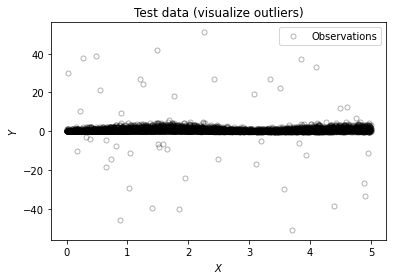

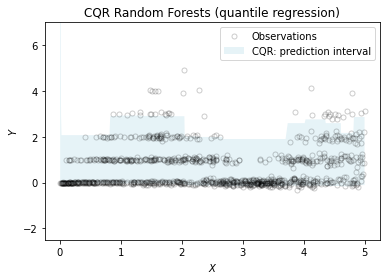

In [192]:
save_figures = False
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'
max_show = 1000

%matplotlib inline
# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')
if save_figures:
    plt.savefig("illustration_test_data.png",
                bbox_inches='tight', dpi=300)
plt.show()

plot_func(x=x_test,y=y_test,y_u=res[:,1],y_l=res[:,0],shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="illustration_split_qrf.png",save_figures=save_figures)

In [128]:
res = np.array(pred_band_mean_based(alpha=0.1,
                         mu_hat_algorithm=random_forest,
                         x_new=x_test,
                         X_train=X_train,
                         y_train=y_train,
                         X_test=X_calib,
                         y_test=y_calib)).T

# compute length of the conformal interval per each test point
length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test >= res[:,0]) & (y_test <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 3.0669401034145314
CQR Random Forests: Percentage in the range (expecting 90.0%): 90.38000000000001


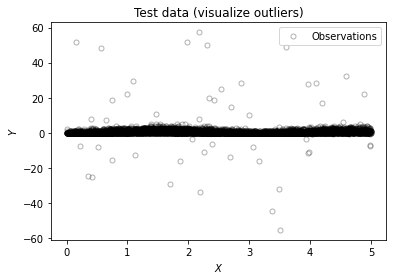

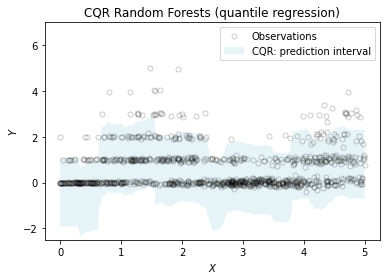

In [120]:
save_figures = False
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'
max_show = 1000

%matplotlib inline
# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')
if save_figures:
    plt.savefig("illustration_test_data.png",
                bbox_inches='tight', dpi=300)
plt.show()

plot_func(x=x_test,y=y_test,y_u=res[:,1],y_l=res[:,0],shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="illustration_split_qrf.png",save_figures=save_figures)

In [266]:
# number of training examples
n_train = 2000
# number of test examples (to evaluate average coverage and length)
n_test = 5000

def f(x):
    ''' Construct data (1D example)
    '''
    ax = 0*x
    for i in range(len(x)):
        ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
        ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
    return ax.astype(np.float32)

# training features
x = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)

# test features
x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

# generate labels
y = f(x)
y_test = f(x_test)

# reshape the features
x = np.reshape(x,(n_train,1))
x_test = np.reshape(x_test,(n_test,1))

X_train, X_calib, y_train, y_calib = split_sample(X=x, y=y.reshape(-1,1), test_size=0.5)

###########
res = np.array(pred_band_weighted_mean_based(alpha=0.1,
                         mu_hat_algorithm=random_forest,
                         mad_hat_algorithm = random_forest,
                         x_new=x_test,
                         X_train=X_train,
                         y_train=y_train,
                         X_test=X_calib,
                         y_test=y_calib)).T


# compute length of the conformal interval per each test point
length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test >= res[:,0]) & (y_test <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)


(1000,)
CQR Random Forests: Average length: 2.7868914420403583
CQR Random Forests: Percentage in the range (expecting 90.0%): 89.46


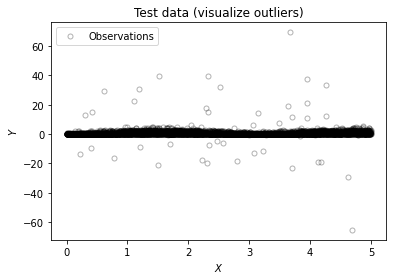

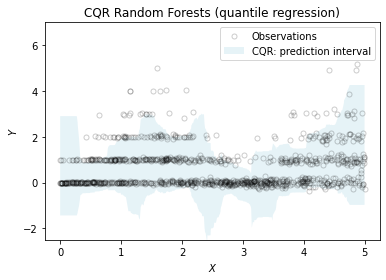

In [268]:
save_figures = False
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'
max_show = 1000

%matplotlib inline
# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')
if save_figures:
    plt.savefig("illustration_test_data.png",
                bbox_inches='tight', dpi=300)
plt.show()

plot_func(x=x_test,y=y_test,y_u=res[:,1],y_l=res[:,0],shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="illustration_split_qrf.png",save_figures=save_figures)

In [66]:
np.random.uniform(0, 5.0, size=10).astype(np.float32)

array([4.452307  , 2.0506976 , 4.1337795 , 0.03695747, 4.173001  ,
       3.5558705 , 3.7046545 , 0.3651614 , 0.61190796, 1.8741726 ],
      dtype=float32)

In [152]:
# number of training examples
n_train = 2000
# number of test examples (to evaluate average coverage and length)
n_test = 3000

def f(x):
    ''' Construct data (1D example)
    '''
    ax = 0*x
    for i in range(len(x)):
        ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
        ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
    return ax.astype(np.float32)

# training features
x = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)

# test features
x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

# generate labels
y = f(x)
y_test = f(x_test)

# reshape the features
x = np.reshape(x,(n_train,1))
x_test = np.reshape(x_test,(n_test,1))

X_train, X_calib, y_train, y_calib = split_sample(X=x, y=y.reshape(-1,1), test_size=0.5)

###########
x_new, conf_set_list, a , b =  pred_band_cdf_based(x_new=x_test, X_train=X_train, y_train=y_train, X_test=X_calib, y_test=y_calib, alpha=0.1, y_grid=None, quantile_grid=None)

res = extract_intervals(conf_set_list)


# compute length of the conformal interval per each test point
length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test >= res[:,0]) & (y_test <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 3.045312941085642
CQR Random Forests: Percentage in the range (expecting 90.0%): 91.46666666666667


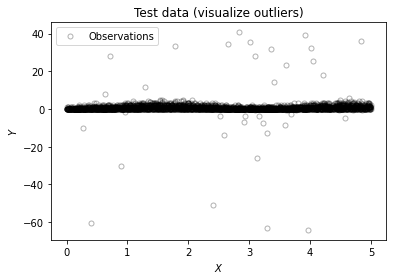

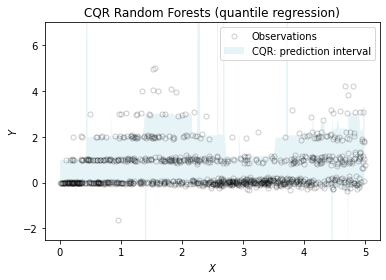

In [149]:
save_figures = False
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'
max_show = 1000

%matplotlib inline
# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')
if save_figures:
    plt.savefig("illustration_test_data.png",
                bbox_inches='tight', dpi=300)
plt.show()

plot_func(x=x_test,y=y_test,y_u=res[:,1],y_l=res[:,0],shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="illustration_split_qrf.png",save_figures=save_figures)

In [56]:
def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False):
    
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.9,
                     label=u'Predicted low and high quantiles')
            plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_[inds,:], pred_[inds], 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

In [69]:
def generate_y(X_mat, eps_dist="normal", error_type="const", functional_form="linear", sigma=1, force_beta_positive=False, non_zero_beta_count=None, magnitude_nonzero_coeffs = 3, signal_noise_ratio=None, alpha=5, df=3):
    
    n, p = X_mat.shape
    
    if non_zero_beta_count is None:
        non_zero_beta_count = int(np.ceil(p / 10))
    
    if non_zero_beta_count is not None:
        if non_zero_beta_count > p:
            raise ValueError('Number of non-zero coefficients cannot exceed the number of covariates in X.')
        else:
            non_zero_beta_count = int(non_zero_beta_count)
        
    # calculate the linear part of the conditional expectation function, or the error multiplicator:
    # Sample s variables uniformly at random, define true coefficients
    
    non_zero_coeffs = np.random.choice(p, size=non_zero_beta_count, replace=False)
    beta = np.zeros(p)
    beta[non_zero_coeffs] = np.random.choice(np.array([-1,1])*magnitude_nonzero_coeffs, size=non_zero_beta_count, replace=True)
    if force_beta_positive:
        beta = np.abs(beta)
    linear_part = X_mat @ beta
    
    
    # main effect:
    if functional_form=="linear":
        mu = linear_part
    
    elif functional_form=="sine":
        mu = 2 * np.sin(np.pi * linear_part) + np.pi * linear_part
        
    elif functional_form=="stochastic_poisson":
        if p > 1:
            raise ValueError('This dgp can only be initialized with p = 1.')
    #    mu = np.zeros(n)
    #    for i in range(n):
    #        mu[i] = np.random.poisson(np.sin(X_mat.flatten()[i])**2 + 0.1)
        else:
            x = X_mat.flatten()
            ax = 0*x
            for i in range(len(x)):
                ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
                ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
            y = ax.astype(np.float32)
            return y, X_mat
        
    else:
        raise ValueError('Please specify regular functional form.')
        
    # error:
    if eps_dist=="normal":
        eps = np.random.normal(0, 1, n)
        
    elif eps_dist=="uniform":
        eps = np.random.uniform(0,1,n)
        
    elif eps_dist=="t":
        eps = np.random.standard_t(df=df, size=n)
    
    elif eps_dist=="skewed_normal":
        eps = skewnorm.rvs(alpha, size=n)
        
    #elif eps_dist=="mixed":
    #    eps_1 = np.random.normal(0, 1, n)
    #    tmp = np.random.uniform(0,1,n)
    #    tmp_2 = np.random.normal(0, 1, n)
    #    eps_2 = 25 * np.int64(tmp < 0.01) * tmp_2
        
    else:
        raise ValueError('Please specify regular error distribution.')
    
    
    if error_type=="const":
        sx = np.ones(n)
        sigma_vec = sigma * sx
    
    elif error_type=="simple_linear":
        sx = linear_part
        sigma_vec = sigma * sx
        
    elif error_type=="varying_third_moment_mu":
        sx = 1 + 2 * np.abs(mu)**3/ np.mean(np.abs(mu)**3)
        sigma_vec = sigma * sx
    
    elif error_type=="varying_squared_linear_part":
        sx = 1 + (linear_part)**2
        sigma_vec = sigma * sx
    
    else:
        raise ValueError('Please specify regular error type.')
        
    
    if eps_dist!="mixed":
        assert eps.shape == (n,)
        
    elif eps_dist=="mixed":
        assert eps_1.shape == (n,)
        assert eps_2.shape == (n,)
        
    assert sigma_vec.shape == (n,)
    assert mu.shape == (n,)
           
    if signal_noise_ratio is not None:
        mu = mu * np.sqrt(signal_noise_ratio) * np.sqrt(np.mean(sigma_vec**2)) / np.std(mu)
    
    assert mu.shape == (n,)
    
    if eps_dist=="mixed":
        y = mu + eps_1 * 0.03 * linear_part.flatten() + eps_2
    else:
        y = mu + eps * sigma_vec
    
    if functional_form!="stochastic_poisson":
        return y, eps, sigma_vec, mu, beta, X_mat
    
    
def generate_X(n, p, X_dist="normal", cor="none", standardize=True, rho=0.5, k=3, alpha=5, uniform_lower=0.0, uniform_upper=1.0):
    
    # Generate X matrix
    if X_dist=="normal":
        X = np.random.normal(0, 1, n*p).reshape((n,p))

    if X_dist=="binom":
        X = np.random.binomial(n=1, p=0.5, size=(n,p))
        
    if X_dist=="uniform":
        X = np.random.uniform(uniform_lower,uniform_upper,n*p).reshape((n,p))
        
    if X_dist=="skewed_normal":
        X = skewnorm.rvs(alpha, size=n*p).reshape((n,p))

    if X_dist=="mixture":
        X = np.zeros(n*p).reshape((n,p))
        
        x1 = np.random.normal(0, 1, n*p).reshape((n,p))
        x2 = np.random.binomial(n=1, p=0.5, size=(n,p))
        x3 = skewnorm.rvs(5, size=n*p).reshape((n,p))
        
        u = np.random.uniform(0,1,p)
        i1 = (u <= 1/3)
        i2 = (1/3 < u) & (u <= 2/3)
        i3 = (u > 2/3)
        
        X[:,i1] = x1[:,i1]
        X[:,i2] = x2[:,i2]
        X[:,i3] = x3[:,i3]
  

    # Pairwise correlation
    if cor=="pair":
        b = (-2 * np.sqrt(1-rho) + 2 * np.sqrt((1 - rho) + p * rho))/(2 * p)
        a = b + np.sqrt(1-rho)
        
        # calculate symmetric square root of p x p matrix whose diagonals are 1 and off diagonals are rho:
        sig_half = np.full(shape=(p,p), fill_value=b)
        np.fill_diagonal(sig_half, a)
        X = X @ sig_half

    # Auto-correlation
    if cor=="auto":
        for j in range(p):
            mat = X[:,max(0,j-k):j+1]
            wts = np.random.uniform(0,1,mat.shape[1]).flatten()
            wts = wts/np.sum(wts)
            tmp = mat * wts
            X[:, j] = np.array(np.mean(tmp, axis=1))
  
    # Standardize, if necessary
    if standardize:
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        
    return X

In [82]:
X_mat = generate_X(n=2000, p=1, X_dist="uniform", cor="none", standardize=False,uniform_lower=0, uniform_upper=5)
X_mat_test = generate_X(n=3000, p=1, X_dist="uniform", cor="none", standardize=False,uniform_lower=0, uniform_upper=5)


y, x = generate_y(X_mat = X_mat, functional_form="stochastic_poisson")

y_test, x_test = generate_y(X_mat = X_mat_test, functional_form="stochastic_poisson")



In [83]:
X_train, X_calib, y_train, y_calib = split_sample(X=x, y=y.reshape(-1,1), test_size=0.5)


#res = pred_band_quantile_based_rf_beta(x_new = x_test, X_train=X_train, y_train=y_train, X_test=X_calib, y_test=y_calib, CV=True, nodesize=150)
res = pred_band_quantile_based_rf(X_predict = x_test, X_train=X_train, y_train=y_train, X_conf=X_calib, y_conf=y_calib, CV=True, nodesize=100)

# compute length of the conformal interval per each test point
length_cqr_rf = res[:,1] - res[:,0]


# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test >= res[:,0]) & (y_test <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 2.2512190396139564
CQR Random Forests: Percentage in the range (expecting 90.0%): 89.8


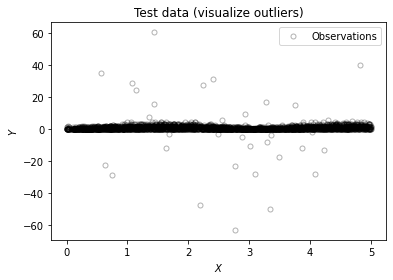

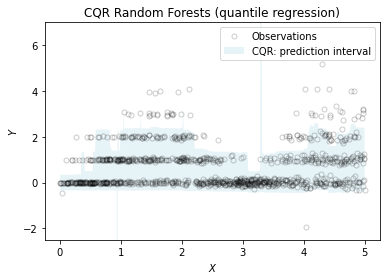

In [84]:
save_figures = False
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'
max_show = 1000

%matplotlib inline
# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')
if save_figures:
    plt.savefig("illustration_test_data.png",
                bbox_inches='tight', dpi=300)
plt.show()

plot_func(x=x_test,y=y_test,y_u=res[:,1],y_l=res[:,0],shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="illustration_split_qrf.png",save_figures=save_figures)